In [1]:
# Install RDKit.
%%capture
!pip install rdkit

In [30]:
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.colors as colors
from mpl_toolkits import mplot3d
from math import sqrt
import warnings
import time

from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,ExtraTreesRegressor,BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model


from rdkit import Chem
from rdkit.Chem import Draw, PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
import pickle
import os
import random
# import os.path as osp

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams["savefig.format"] = 'tiff'
warnings.filterwarnings("ignore")

In [3]:
seed = 115
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [33]:
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.7)


In [34]:
# Learning Rate Scheduler
def scheduler(epoch, lr):
  if epoch < 160:
    return lr
  else:
    return lr * np.exp(-0.1)

callback = keras.callbacks.LearningRateScheduler(scheduler)



# Neural Network
def Neural_network():
    init = keras.initializers.random_normal()
    model=Sequential()
    model.add(layers.Dense(64,activation='relu',kernel_initializer=init, input_dim=scaled_DF.shape[1]))
    model.add(layers.Dropout(0.1))


    model.add(layers.Dense(128,activation='relu',kernel_initializer=init))
    model.add(layers.Dropout(0.1))


    model.add(layers.Dense(128,activation='relu',kernel_initializer=init))
    model.add(layers.Dropout(0.1))


    model.add(layers.Dense(1,kernel_initializer=init,activation = 'linear'))


    optimize=tf.keras.optimizers.Adam()

    model.compile(optimizer=optimize,
                    loss='mse',
                    )
    return model



In [35]:
# Funtion to train the model
def training_model(X_train,Y_train,model):
    history=model.fit(X_train,Y_train,epochs=200,batch_size=32,verbose=0,callbacks=[callback])
    return history

In [44]:
# To print losses
def plots():
    f, ax = plt.subplots(1,1)
    actual_test=np.array(scaler.inverse_transform(testY).reshape(-1,1))
    predicted_test=np.array(scaler.inverse_transform(model.predict(testX).reshape(-1,1)))

    #actual=testY
    #predicted= model.predict(testX)

    actual=np.array(scaler.inverse_transform(np.array(trainY).reshape(-1,1)))
    predicted=np.array(scaler.inverse_transform(model.predict(np.array(trainX)).reshape(-1,1)))

    plt.rcParams["figure.figsize"] = (6,6)
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams["savefig.format"] = 'tiff'

    sns.set(style='whitegrid')
    sns.set_context("paper", font_scale=1.7)

    plt.scatter(actual_test,predicted_test, color='purple', label='Test', linewidths=1, edgecolors='black', s=75)
    sns.regplot(x=actual,y=predicted, color='orangered', label='Train', scatter_kws={'s':40, 'alpha':0.5, 'edgecolor':'black'})

    print("Mean absolute error (MAE):      %f" % mean_absolute_error(actual_test,predicted_test))
    print("Mean squared error (MSE):       %f" % mean_squared_error(actual_test,predicted_test))
    print("Root mean squared error (RMSE): %f" % sqrt(mean_squared_error(actual_test,predicted_test)))
    print("R square (R^2):                 %f" % r2_score(actual_test,predicted_test))


    plt.xlabel("Hammett's Constants (Actual)")
    plt.ylabel('Predicted')
    #plt.suptitle("Actual Vs Predicted")
    anchored_text = AnchoredText("R\u00b2 Score_train  "+str(round(r2_score(actual,predicted),3))+'\n'"R\u00b2 Score_test  "+str(round(r2_score(actual_test,predicted_test),3)), loc=2,prop=dict(size=10))
    #anchored_text = AnchoredText("R\u00b2 Score =  "+str(round(r2_score(actual_test,predicted_test),3)), loc=2,prop=dict(size=15))
    ax.add_artist(anchored_text)

    plt.legend(loc = 9, prop={'size': 10}) #labels=["Test","Train"],
    plt.tight_layout()
    plt.savefig(str(model)[1:6], bbox_inches='tight')

In [37]:
def defining_model(x):
    if x == 'mlr':
      model = LinearRegression()
    elif x=='adboost':
      model = AdaBoostRegressor(random_state=42)
    elif x=='xtratree':
      model = ExtraTreesRegressor(random_state=42)
    elif x=='bagging':
      model = BaggingRegressor(random_state=42)
    elif x=='pls':
      model = PLSRegression()
    elif x=='rndmfrst':
      model = RandomForestRegressor(random_state=42)
    elif x=='knn':
      model = KNeighborsRegressor()
    elif x=='svr':
      model = SVR()
    else:
      print("wrong selection")
    return model

In [38]:
df = pd.read_excel(
    'final_data.xlsx'
)

In [12]:
df.head(2)

,ID,SMILES,Sigma,NBO_CC,NBO_SC,E(HOMO),ABC,nAcid,nBase,SpMAD_A,...,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,TopoShapeIndex,Lipinski,GhoseFilter,Type
0,B1,O=C(O)c1cccc(B(F)F)c1,0.32,-0.183,-0.489,-0.28817,8.841960,1,0,1.198270,...,0.049293,0.059028,0.0,0.0,0.0,0.0,1.000000,1,0,m
1,B2,O=C(O)c1cccc(Br)c1,0.39,-0.162,-0.130,-0.26324,7.358797,1,0,1.190868,...,0.066032,0.031250,0.0,0.0,0.0,0.0,0.666667,1,0,m


In [13]:
with open('train_ids', 'rb') as f:
    train_ids = pickle.load(f)

Train = df[df.ID.isin(train_ids)]
Test = df[~df.ID.isin(train_ids)]

In [14]:
# Train.to_excel('Train.xlsx', index=None)
# Test.to_excel('Test.xlsx', index=None)

In [15]:
Train.shape

(835, 287)

In [16]:
Test.shape

(147, 287)

In [17]:
Train.head(2)

,ID,SMILES,Sigma,NBO_CC,NBO_SC,E(HOMO),ABC,nAcid,nBase,SpMAD_A,...,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,TopoShapeIndex,Lipinski,GhoseFilter,Type
1,B2,O=C(O)c1cccc(Br)c1,0.39,-0.162,-0.130,-0.26324,7.358797,1,0,1.190868,...,0.066032,0.031250,0.0,0.0,0.0,0.0,0.666667,1,0,m
2,B3,O=C(O)c1cccc([Ge](Br)(Br)Br)c1,0.66,-0.169,-0.515,-0.29236,9.785874,1,0,1.152159,...,0.052308,0.064583,0.0,0.0,0.0,0.0,1.000000,1,0,m


In [21]:
# Combine Train and test for feature engineering
DF_raw = pd.concat([Train,Test],ignore_index=True)
DF_data = DF_raw.copy()

In [22]:
# Removing Unwanted columns
DF_data=DF_data.drop(['SMILES', 'ID', 'Type'],axis=1)
DF_data.head(2)

,Sigma,NBO_CC,NBO_SC,E(HOMO),ABC,nAcid,nBase,SpMAD_A,nAromAtom,nBridgehead,...,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,TopoShapeIndex,Lipinski,GhoseFilter
0,0.39,-0.162,-0.130,-0.26324,7.358797,1,0,1.190868,6,0,...,0.056818,0.066032,0.031250,0.0,0.0,0.0,0.0,0.666667,1,0
1,0.66,-0.169,-0.515,-0.29236,9.785874,1,0,1.152159,6,0,...,0.058824,0.052308,0.064583,0.0,0.0,0.0,0.0,1.000000,1,0


In [ ]:
# DF_data = DF_data[['E(HOMO)', 'NBO_CC', 'AATS3Z', 'ATSC5s', 'GATS1Z', 'BCUTs-1l',
#        'NBO_SC', 'IC0', 'GATS2Z', 'AATS6Z', 'PEOE_VSA1', 'JGI2',
#        'PEOE_VSA5', 'nI', 'BCUTd-1l', 'Sigma']]

#['E(HOMO)', 'NBO_CC', 'AATS3Z', 'ATSC5s', 'GATS1Z', 'BCUTs-1l',
#      'NBO_SC', 'IC0', 'GATS2Z', 'AATS6Z', 'Sigma']


In [23]:
# Scaling the whole DataFrame

scaler = StandardScaler()
scaled_DF = pd.DataFrame(scaler.fit_transform(DF_data.iloc[:,1:]))
scaled_DF.columns = DF_data.iloc[:,1:].columns

scaled_DF['Sigma'] = scaler.fit_transform(np.array(DF_data['Sigma']).reshape(-1,1))
scaled_DF

display(scaled_DF)

,NBO_CC,NBO_SC,E(HOMO),ABC,nAcid,nBase,SpMAD_A,nAromAtom,nBridgehead,nHetero,...,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,TopoShapeIndex,Lipinski,GhoseFilter,Sigma
0,0.483046,-0.117802,-0.025916,-1.297898,-0.208986,-0.234706,-0.320117,-0.500555,-0.045175,-0.705760,...,2.325514,-0.798213,-1.784285,-1.119764,-0.723329,-0.521189,-1.900144,0.144187,-1.720371,0.272573
1,0.068662,-1.520544,-0.639861,-0.571705,-0.208986,-0.234706,-0.951716,-0.500555,-0.045175,0.418723,...,0.948562,1.297712,-1.784285,-1.119764,-0.723329,-0.521189,0.979871,0.144187,-1.720371,1.029008
2,-0.168129,-1.746440,-0.497760,-0.571705,-0.208986,-0.234706,-0.951716,-0.500555,-0.045175,0.418723,...,0.948562,1.297712,-1.784285,-1.119764,-0.723329,-0.521189,0.979871,0.144187,-1.720371,0.524718
3,0.483046,0.140885,-0.120369,-1.297898,-0.208986,-0.234706,-0.320117,-0.500555,-0.045175,-0.705760,...,2.325514,-0.798213,-1.784285,-1.119764,-0.723329,-0.521189,-1.900144,0.144187,-1.720371,0.216540
4,0.187057,-1.170769,-0.374845,-1.119058,-0.208986,-0.234706,0.441976,-0.500555,-0.045175,-0.330932,...,1.299198,0.366190,-1.784285,-1.119764,-0.723329,-0.521189,0.979871,0.144187,-1.720371,0.104476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,-0.227326,-1.549692,-0.066185,2.252428,-0.208986,-0.234706,-2.296060,-0.500555,-0.045175,1.543206,...,0.261822,0.811938,-1.034411,1.398200,2.833304,-0.521189,-0.748138,0.144187,0.581270,-0.848073
978,-2.062455,1.059044,1.200499,1.595049,-0.208986,-0.234706,1.760926,2.636968,-0.045175,-0.705760,...,-1.651905,-2.233869,-0.762650,0.568753,0.659806,1.030840,0.979871,0.144187,0.581270,-1.436412
979,-0.404919,-0.842856,0.699560,1.595049,-0.208986,-0.234706,1.760926,2.636968,-0.045175,-0.705760,...,-1.651905,-2.233869,-0.762650,0.568753,0.659806,1.030840,0.979871,0.144187,0.581270,-0.287750
980,0.423848,-0.999526,0.730974,1.835166,-0.208986,-0.234706,1.795729,2.636968,-0.045175,-0.330932,...,-1.659239,-1.853453,-0.595746,0.415251,0.659806,1.030840,0.979871,0.144187,0.581270,0.496702


In [24]:
DF_target = scaled_DF[['Sigma']]
scaled_DF.drop('Sigma',axis=1,inplace=True)

display(scaled_DF)
display(DF_target)

,NBO_CC,NBO_SC,E(HOMO),ABC,nAcid,nBase,SpMAD_A,nAromAtom,nBridgehead,nHetero,...,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,TopoShapeIndex,Lipinski,GhoseFilter
0,0.483046,-0.117802,-0.025916,-1.297898,-0.208986,-0.234706,-0.320117,-0.500555,-0.045175,-0.705760,...,0.352687,2.325514,-0.798213,-1.784285,-1.119764,-0.723329,-0.521189,-1.900144,0.144187,-1.720371
1,0.068662,-1.520544,-0.639861,-0.571705,-0.208986,-0.234706,-0.951716,-0.500555,-0.045175,0.418723,...,0.478073,0.948562,1.297712,-1.784285,-1.119764,-0.723329,-0.521189,0.979871,0.144187,-1.720371
2,-0.168129,-1.746440,-0.497760,-0.571705,-0.208986,-0.234706,-0.951716,-0.500555,-0.045175,0.418723,...,0.478073,0.948562,1.297712,-1.784285,-1.119764,-0.723329,-0.521189,0.979871,0.144187,-1.720371
3,0.483046,0.140885,-0.120369,-1.297898,-0.208986,-0.234706,-0.320117,-0.500555,-0.045175,-0.705760,...,0.352687,2.325514,-0.798213,-1.784285,-1.119764,-0.723329,-0.521189,-1.900144,0.144187,-1.720371
4,0.187057,-1.170769,-0.374845,-1.119058,-0.208986,-0.234706,0.441976,-0.500555,-0.045175,-0.330932,...,-0.193869,1.299198,0.366190,-1.784285,-1.119764,-0.723329,-0.521189,0.979871,0.144187,-1.720371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,-0.227326,-1.549692,-0.066185,2.252428,-0.208986,-0.234706,-2.296060,-0.500555,-0.045175,1.543206,...,2.606056,0.261822,0.811938,-1.034411,1.398200,2.833304,-0.521189,-0.748138,0.144187,0.581270
978,-2.062455,1.059044,1.200499,1.595049,-0.208986,-0.234706,1.760926,2.636968,-0.045175,-0.705760,...,-0.120995,-1.651905,-2.233869,-0.762650,0.568753,0.659806,1.030840,0.979871,0.144187,0.581270
979,-0.404919,-0.842856,0.699560,1.595049,-0.208986,-0.234706,1.760926,2.636968,-0.045175,-0.705760,...,-0.120995,-1.651905,-2.233869,-0.762650,0.568753,0.659806,1.030840,0.979871,0.144187,0.581270
980,0.423848,-0.999526,0.730974,1.835166,-0.208986,-0.234706,1.795729,2.636968,-0.045175,-0.330932,...,0.607746,-1.659239,-1.853453,-0.595746,0.415251,0.659806,1.030840,0.979871,0.144187,0.581270


,Sigma
0,0.272573
1,1.029008
2,0.524718
3,0.216540
4,0.104476
...,...
977,-0.848073
978,-1.436412
979,-0.287750
980,0.496702


In [25]:
trainX = scaled_DF[:len(Train)]
testX = scaled_DF[len(Train):]

trainY = DF_target[:len(Train)]
testY = DF_target[len(Train):]

In [26]:
trainX.shape

(835, 283)

In [28]:
testX.shape

(147, 283)

## **Model screening with 283 descriptors**

Average validation R2 score after crossvalidation :  0.742042447933071
Average validation rmse score after crossvalidation :  0.180008972682267


Training Accuracy :  0.9336218200913448
Mean absolute error (MAE):      0.080899
Mean squared error (MSE):       0.012977
Root mean squared error (RMSE): 0.113915
R square (R^2):                 0.882217


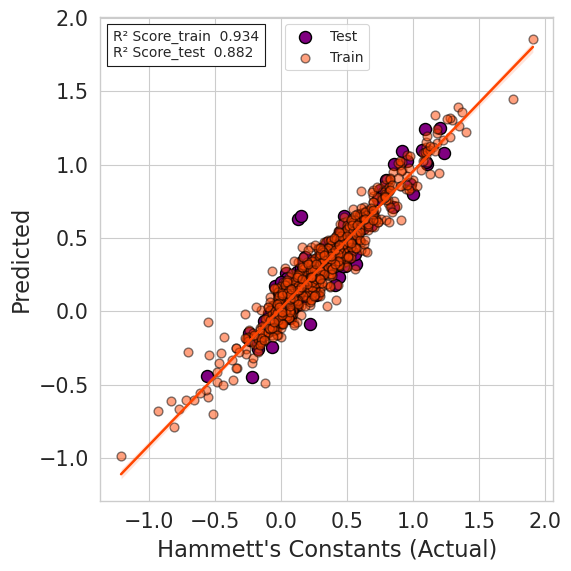

In [48]:
# Multiple Linear Regression
model = defining_model(x = 'mlr')

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  model.fit(trainX.iloc[train],trainY.iloc[train])
  scores.append(model.score(trainX.iloc[valid],trainY.iloc[valid]))
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted))))
# Unscaled

print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))

# Train model on whole train data
model = defining_model(x = 'mlr')
model.fit(trainX,trainY)
print("\n\nTraining Accuracy : ",model.score(trainX,trainY)) # Training Accuracy
plots()

Average validation R2 score after crossvalidation :  0.6754179383453186
Average validation rmse score after crossvalidation :  0.2046118753290834


Training Accuracy :  0.7185633289968181
Mean absolute error (MAE):      0.140994
Mean squared error (MSE):       0.032157
Root mean squared error (RMSE): 0.179324
R square (R^2):                 0.708121


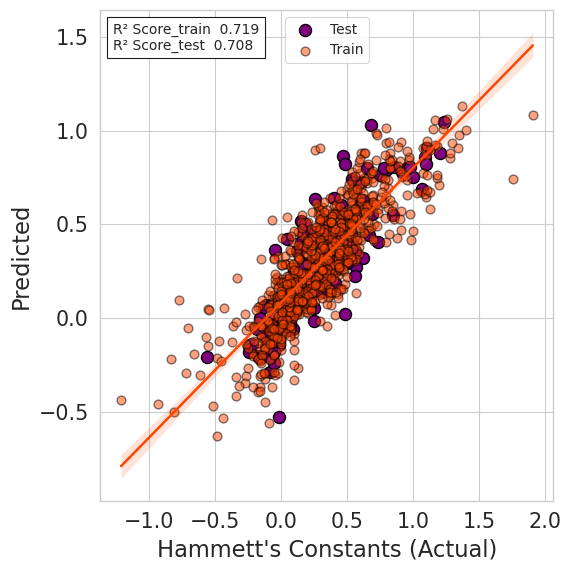

In [46]:
# Partial Least Square
model = defining_model(x = 'pls')

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  model.fit(trainX.iloc[train],trainY.iloc[train])
  scores.append(model.score(trainX.iloc[valid],trainY.iloc[valid]))
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted))))
# Unscaled

print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))

# Train model on whole train data
model = defining_model(x = 'pls')
model.fit(trainX,trainY)
print("\n\nTraining Accuracy : ",model.score(trainX,trainY)) # Training Accuracy
plots()

Average validation R2 score after crossvalidation :  0.6164206552829683
Average validation rmse score after crossvalidation :  0.2220092111257977


Training Accuracy :  0.7791488035023784
Mean absolute error (MAE):      0.145007
Mean squared error (MSE):       0.034108
Root mean squared error (RMSE): 0.184683
R square (R^2):                 0.690414


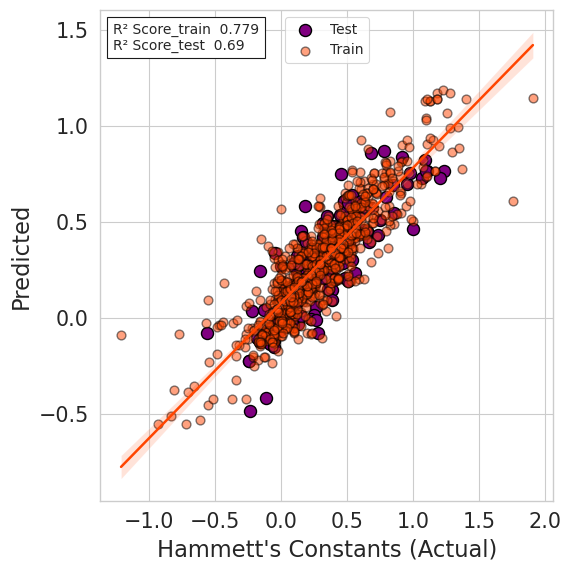

In [49]:
# KNN
model = defining_model(x = 'knn')

kfold = KFold(n_splits=5, shuffle=True)

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  model.fit(trainX.iloc[train],trainY.iloc[train])
  scores.append(model.score(trainX.iloc[valid],trainY.iloc[valid]))
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted))))
# Unscaled

print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))

# Train model on whole train data
model = defining_model(x = 'knn')
model.fit(trainX,trainY)
print("\n\nTraining Accuracy : ",model.score(trainX,trainY)) # Training Accuracy
plots()

Average validation R2 score after crossvalidation :  0.7630513732996779
Average validation rmse score after crossvalidation :  0.173813603499263


Training Accuracy :  0.9266839483268505
Mean absolute error (MAE):      0.088637
Mean squared error (MSE):       0.016059
Root mean squared error (RMSE): 0.126726
R square (R^2):                 0.854234


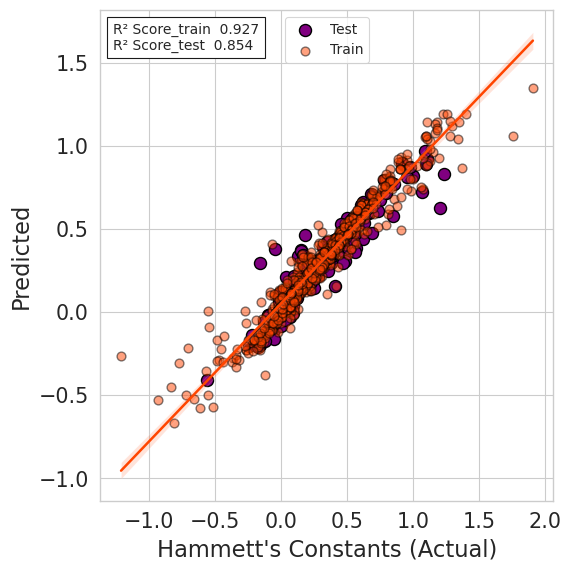

In [50]:
# Support Vector Regressor
model = defining_model(x = 'svr')

kfold = KFold(n_splits=5, shuffle=True)

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  model.fit(trainX.iloc[train],trainY.iloc[train])
  scores.append(model.score(trainX.iloc[valid],trainY.iloc[valid]))
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted.reshape(-1,1)))))
# Unscaled

print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))

# Train model on whole train data
model = defining_model(x = 'svr')
model.fit(trainX,trainY)
print("\n\nTraining Accuracy : ",model.score(trainX,trainY)) # Training Accuracy
plots()

Average validation R2 score after crossvalidation :  0.714143043328695
Average validation rmse score after crossvalidation :  0.1906760428078607


Training Accuracy :  0.8157212578879223
Mean absolute error (MAE):      0.135189
Mean squared error (MSE):       0.028903
Root mean squared error (RMSE): 0.170008
R square (R^2):                 0.737661


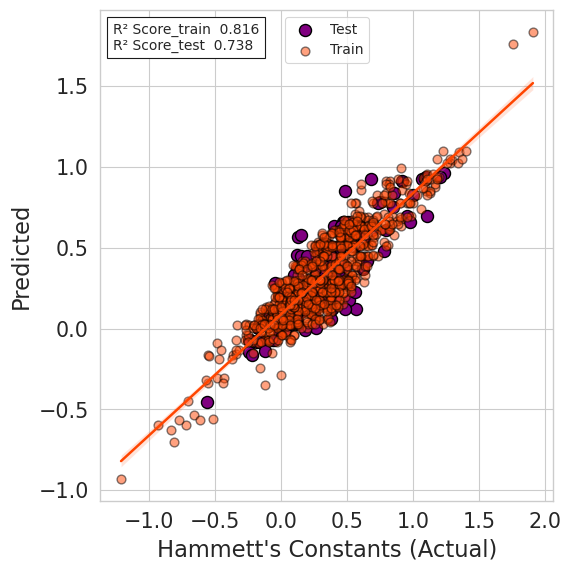

In [51]:
#Adaboost
model = defining_model(x = 'adboost')
kfold = KFold(n_splits=5, shuffle=True)

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  model.fit(trainX.iloc[train],trainY.iloc[train])
  scores.append(model.score(trainX.iloc[valid],trainY.iloc[valid]))
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted.reshape(-1,1)))))

print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))


# Train model on whole train data
model = defining_model(x = 'adboost')
model.fit(trainX,trainY)
print("\n\nTraining Accuracy : ",model.score(trainX,trainY)) # Training Accuracy
plots()

Average validation R2 score after crossvalidation :  0.8750701910955649
Average validation rmse score after crossvalidation :  0.12625619926088133


Training Accuracy :  1.0
Mean absolute error (MAE):      0.080699
Mean squared error (MSE):       0.016607
Root mean squared error (RMSE): 0.128868
R square (R^2):                 0.849265


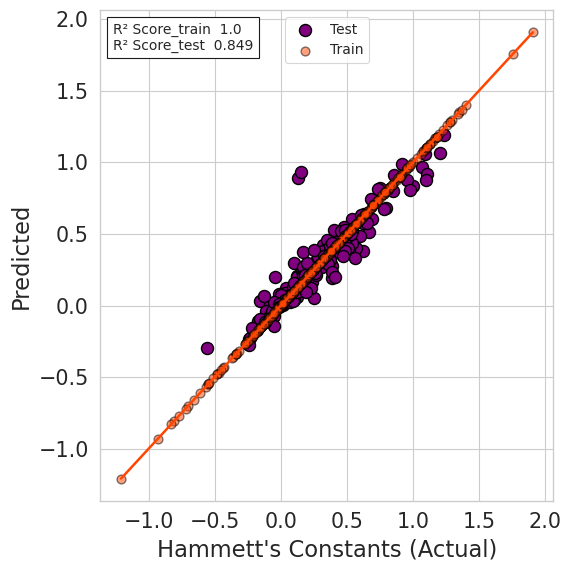

In [52]:
# Extra Tree Regressor
model = defining_model(x = 'xtratree')
kfold = KFold(n_splits=5, shuffle=True)

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  model.fit(trainX.iloc[train],trainY.iloc[train])
  scores.append(model.score(trainX.iloc[valid],trainY.iloc[valid]))
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted.reshape(-1,1)))))

print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))


# Train model on whole train data
model = defining_model(x = 'xtratree')
model.fit(trainX,trainY)
print("\n\nTraining Accuracy : ",model.score(trainX,trainY)) # Training Accuracy
plots()

In [ ]:
# Save the model
# filename = 'et_model.sav'
# pickle.dump(model, open(filename, 'wb'))

In [ ]:
# Load the model
# model = pickle.load(open("et_model.sav", 'rb'))


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'NBO_CC'),
  Text(1, 0, 'E(HOMO)'),
  Text(2, 0, 'IC0'),
  Text(3, 0, 'nBase'),
  Text(4, 0, 'AATS3Z'),
  Text(5, 0, 'nHetero'),
  Text(6, 0, 'nBondsD'),
  Text(7, 0, 'NBO_SC'),
  Text(8, 0, 'AATS7dv'),
  Text(9, 0, 'PEOE_VSA1')])

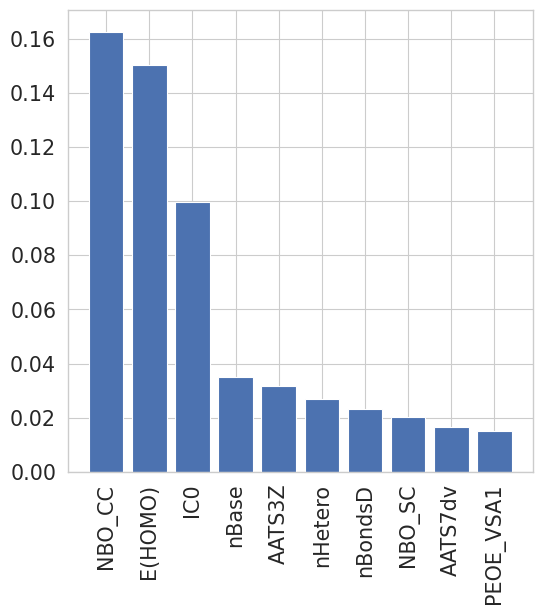

In [55]:
# get importance
importance = model.feature_importances_
# summarize feature importance
dicts = {
    'Feature':[x for x in trainX.columns],
    'Importance':importance
    }
DF_imp = pd.DataFrame(dicts)
DF_imp = DF_imp.sort_values('Importance',ascending=False)
DF_imp.to_excel('imp.xlsx', index=None)

#plot feature importance
plt.bar('Feature','Importance',data = DF_imp.iloc[:10,:])
plt.xticks(rotation = 90)


In [56]:
# fig, ax = plt.subplots(figsize=(10, 12))
# ba = sns.barplot(x = 'Feature', y='Importance', data=imp.iloc[:10,:], palette="Set2", )
# def autolabel(rects):
#     for rect in rects:
#         height = rect.get_height()
#         ax.text(rect.get_x() + rect.get_width() / 2., 0.5 * height,
#                 height,
#                 ha='center', va='bottom', rotation=90, color='white')
# labels = imp['Feature'][:10]
# autolabel(ax.patches)
# ba.set_xticklabels(labels =labels, rotation=45)
# plt.ylabel( 'Feature Importance')
# plt.savefig('featureimp.tiff', bbox_inches='tight')

In [58]:
DF_imp.head(2)

,Feature,Importance
0,NBO_CC,0.162520
2,E(HOMO),0.150451


In [59]:
DF_imp['Feature'].values[:20]

array(['NBO_CC', 'E(HOMO)', 'IC0', 'nBase', 'AATS3Z', 'nHetero',
       'nBondsD', 'NBO_SC', 'AATS7dv', 'PEOE_VSA1', 'BCUTs-1l',
       'EState_VSA6', 'nI', 'GATS1Z', 'ATSC5s', 'PEOE_VSA10', 'JGI2',
       'ETA_beta_ns_d', 'NddssS', 'AATSC0v'], dtype=object)

Average validation R2 score after crossvalidation :  0.813571760783051
Average validation rmse score after crossvalidation :  0.1552746274584547


Training Accuracy :  0.9771442384143808
Mean absolute error (MAE):      0.088371
Mean squared error (MSE):       0.013932
Root mean squared error (RMSE): 0.118032
R square (R^2):                 0.873548


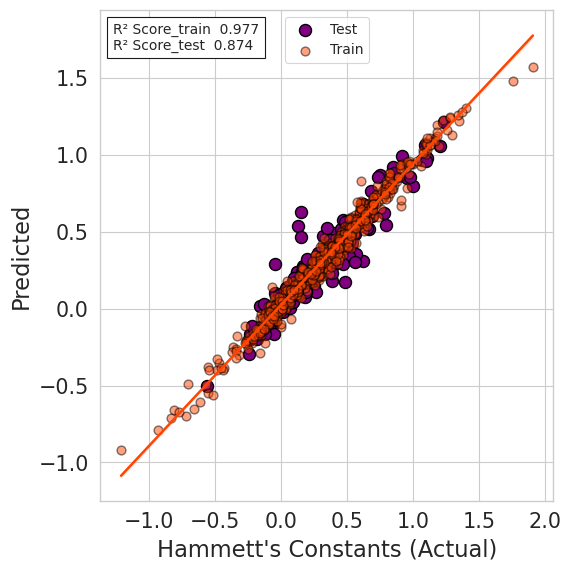

In [61]:
# Random Forest
model = defining_model(x = 'rndmfrst')
kfold = KFold(n_splits=5, shuffle=True)

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  model.fit(trainX.iloc[train],trainY.iloc[train])
  scores.append(model.score(trainX.iloc[valid],trainY.iloc[valid]))
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted.reshape(-1,1)))))

print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))


# Train model on whole train data
model = defining_model(x = 'rndmfrst')
model.fit(trainX,trainY)
print("\n\nTraining Accuracy : ",model.score(trainX,trainY)) # Training Accuracy
plots()

In [66]:
model = Neural_network()

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  model = Neural_network()
  training_model(trainX.iloc[train],trainY.iloc[train],model)
  scores.append(r2_score(trainY.iloc[valid],model.predict(trainX.iloc[valid])))

  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted))))

print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))

# # # Train model on whole train data

# model = Neural_network()
training_model(trainX,trainY,model)


actual=np.array(scaler.inverse_transform(np.array(trainY)))
predicted=np.array(scaler.inverse_transform(model.predict(np.array(trainX)).reshape(-1,1)))
# model.save("nn.h5")
# model.save('nn.keras')
score = r2_score(actual,predicted)
print("\n\nTraining Accuracy : ",score) # Training Accuracy
# plots()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Average validation R2 score after crossvalidation :  0.8534466981887817
Average validation rmse score after crossvalidation :  0.13685423065562685
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Training Accuracy :  0.9936057755018952


In [67]:
model = keras.models.load_model('nn.keras')

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean absolute error (MAE):      0.067259
Mean squared error (MSE):       0.008262
Root mean squared error (RMSE): 0.090894
R square (R^2):                 0.925011


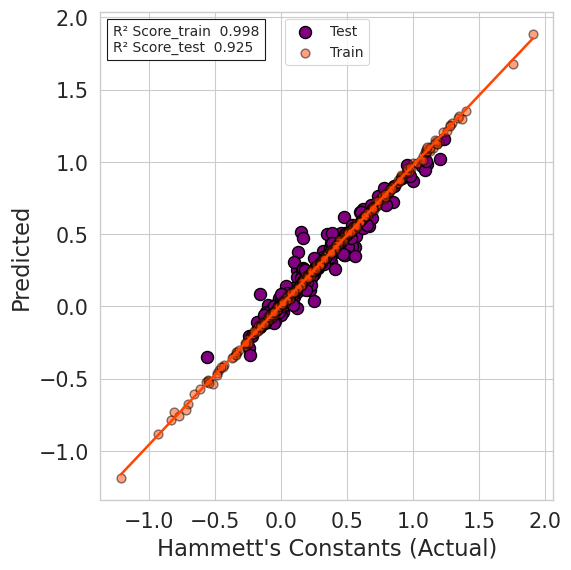

In [68]:
plots()

## **Model Screening**

Average validation R2 score after crossvalidation :  0.7230290779938591
Average validation rmse score after crossvalidation :  0.18816551074455218


Training Accuracy :  0.9999444255073803
Mean absolute error (MAE):      0.117939
Mean squared error (MSE):       0.031641
Root mean squared error (RMSE): 0.177879
R square (R^2):                 0.712805


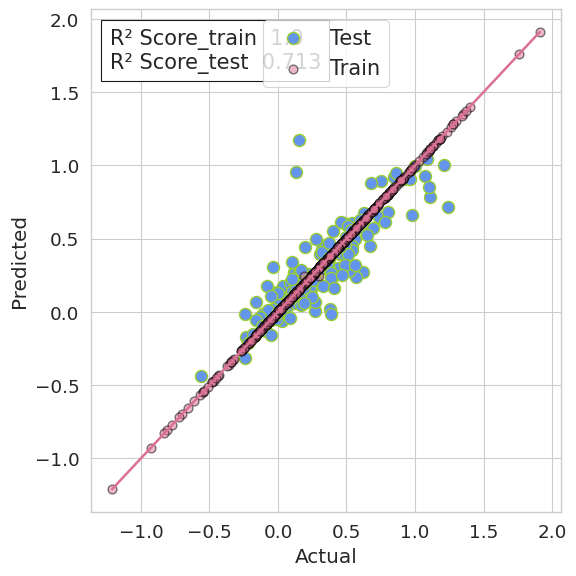

In [ ]:
# Extra Tree Regressor
model = defining_model(x = 'xtratree')
kfold = KFold(n_splits=5, shuffle=True)

scores = []
rmse = []
for train,valid in kfold.split(trainX,trainY):
  model.fit(trainX.iloc[train],trainY.iloc[train])
  scores.append(model.score(trainX.iloc[valid],trainY.iloc[valid]))
  actual = trainY.iloc[valid]
  predicted = model.predict(trainX.iloc[valid])
  rmse.append(sqrt(mean_squared_error(scaler.inverse_transform(actual),scaler.inverse_transform(predicted.reshape(-1,1)))))

print("Average validation R2 score after crossvalidation : ", np.mean(scores))
print("Average validation rmse score after crossvalidation : ", np.mean(rmse))


# Train model on whole train data
model = defining_model(x = 'xtratree')
model.fit(trainX,trainY)
print("\n\nTraining Accuracy : ",model.score(trainX,trainY)) # Training Accuracy
plots()

## **Hyperparameter Tuning**

# For ET model

In [70]:
dataX = pd.concat([trainX, testX], axis=0)

In [71]:
dataX.shape

(982, 283)

In [72]:
dataX.head(2)

,NBO_CC,NBO_SC,E(HOMO),ABC,nAcid,nBase,SpMAD_A,nAromAtom,nBridgehead,nHetero,...,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,TopoShapeIndex,Lipinski,GhoseFilter
0,0.483046,-0.117802,-0.025916,-1.297898,-0.208986,-0.234706,-0.320117,-0.500555,-0.045175,-0.705760,...,0.352687,2.325514,-0.798213,-1.784285,-1.119764,-0.723329,-0.521189,-1.900144,0.144187,-1.720371
1,0.068662,-1.520544,-0.639861,-0.571705,-0.208986,-0.234706,-0.951716,-0.500555,-0.045175,0.418723,...,0.478073,0.948562,1.297712,-1.784285,-1.119764,-0.723329,-0.521189,0.979871,0.144187,-1.720371


In [73]:
dataY = pd.concat([trainY, testY], axis=0)

In [74]:
et = ExtraTreesRegressor(bootstrap=False,
                           max_depth=None,
                           max_features=1.0,
                           min_samples_leaf=1,
                           min_samples_split=2,
                           n_estimators=100)

In [ ]:
clf_et = GridSearchCV(estimator=et, param_grid = {'bootstrap': [True, False],
 'max_depth': [10, 30, 60, None],
 'max_features': ['log2', 'sqrt',  1],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 400, 600]}, cv=3, verbose=0, scoring='r2')

In [ ]:
start = time.time()
clf_et.fit(dataX, dataY)
end = time.time()
# total time taken
print("Execution time of the program is- ", end-start)

Execution time of the program is-  1627.3145968914032


In [ ]:
et_hyper = pd.DataFrame(clf_et.cv_results_).sort_values('mean_test_score', ascending=False)
et_hyper.to_excel('et_hyper.xlsx', index=False)

In [ ]:
clf_et.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 600}

## **Regression Plots**

In [76]:
model = keras.models.load_model('nn_tuned.keras')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean absolute error (MAE):      0.065359
Mean squared error (MSE):       0.007155
Root mean squared error (RMSE): 0.084585
R square (R^2):                 0.935060


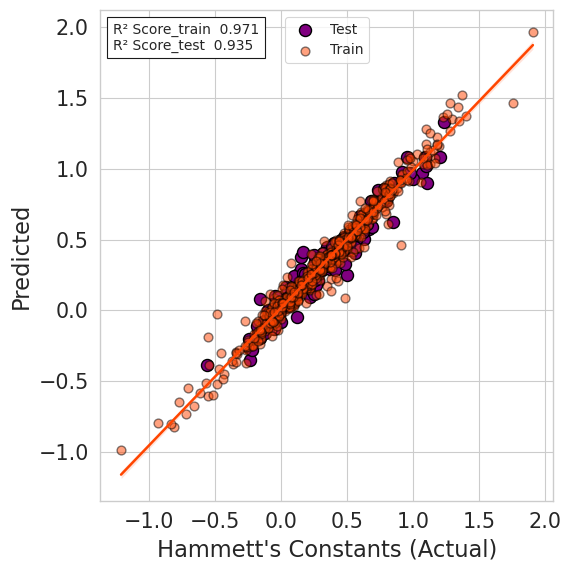

In [77]:
plots()

In [78]:
Test.head(2)

,ID,SMILES,Sigma,NBO_CC,NBO_SC,E(HOMO),ABC,nAcid,nBase,SpMAD_A,...,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,TopoShapeIndex,Lipinski,GhoseFilter,Type
0,B1,O=C(O)c1cccc(B(F)F)c1,0.32,-0.183,-0.489,-0.28817,8.841960,1,0,1.198270,...,0.049293,0.059028,0.0,0.0,0.0,0.0,1.0,1,0,m
21,B22,O=C(O)c1cccc([Ge](F)(F)F)c1,0.85,-0.168,-0.562,-0.30654,9.785874,1,0,1.152159,...,0.052308,0.064583,0.0,0.0,0.0,0.0,1.0,1,0,m


In [79]:
actual_test=np.array(scaler.inverse_transform(testY).reshape(-1,1))
predicted_test=np.array(scaler.inverse_transform(model.predict(testX).reshape(-1,1)))

predictions_DF = Test[['ID', 'Type', 'SMILES', 'Sigma']]
predictions_DF['Actual'] = np.squeeze(actual_test)
predictions_DF['Predicted'] = np.squeeze(np.round(predicted_test,2))

predictions_DF.to_excel('predictions_test_nn.xlsx',index = False)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [80]:
ptest_nn = pd.read_excel('predictions_test_nn.xlsx')
ptest_nn.head()

,ID,Type,SMILES,Sigma,Actual,Predicted
0,B1,m,O=C(O)c1cccc(B(F)F)c1,0.32,0.32,0.30
1,B22,m,O=C(O)c1cccc([Ge](F)(F)F)c1,0.85,0.85,0.63
2,B24,m,O=C(O)c1cccc([Si](F)(F)F)c1,0.54,0.54,0.44
3,B25,m,O=C(O)c1cccc(I(F)(F)(F)F)c1,1.07,1.07,0.97
4,B31,m,O=Nc1cccc(C(=O)O)c1,0.62,0.62,0.52


In [81]:
actual=np.array(scaler.inverse_transform(np.array(trainY).reshape(-1,1)))
predicted=np.array(scaler.inverse_transform(model.predict(np.array(trainX)).reshape(-1,1)))

predictions_DF = Train[['ID', 'Type', 'SMILES', 'Sigma']]
predictions_DF['Actual'] = np.squeeze(actual)
predictions_DF['Predicted'] = np.squeeze(np.round(predicted, 2))

predictions_DF.to_excel('predictions_train_nn.xlsx',index = False)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [82]:
ptrain_nn = pd.read_excel('predictions_train_nn.xlsx')
ptrain_nn.head()

,ID,Type,SMILES,Sigma,Actual,Predicted
0,B2,m,O=C(O)c1cccc(Br)c1,0.39,0.39,0.40
1,B3,m,O=C(O)c1cccc([Ge](Br)(Br)Br)c1,0.66,0.66,0.70
2,B4,m,O=C(O)c1cccc([Si](Br)(Br)Br)c1,0.48,0.48,0.47
3,B5,m,O=C(O)c1cccc(Cl)c1,0.37,0.37,0.36
4,B6,m,O=C(O)c1cccc([Hg]Cl)c1,0.33,0.33,0.36


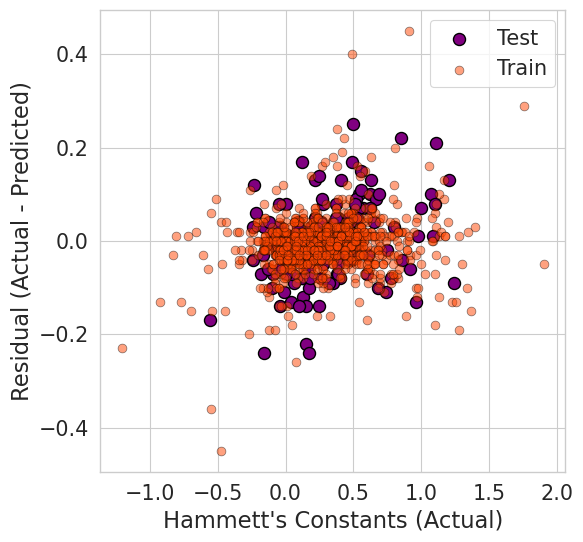

In [83]:
# For Neural Network model
# import matplotlib
# TOR = df['Type']
# TOR = LabelEncoder().fit_transform(TOR)
x = ptest_nn['Actual']
y = ptest_nn['Predicted']
z= x - y

a = ptrain_nn['Actual']
b = ptrain_nn['Predicted']
c= a - b

# TOR = df['Type']
# TOR = LabelEncoder().fit_transform(TOR)
#cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['cornflowerblue','palevioletred'])
plt.scatter(x,z, color='purple', label='Test', linewidths=1, edgecolors='black', s=75)
sns.scatterplot(x=a,y=c, color='orangered',label='Train', alpha = 0.5, s = 40, edgecolor='black')
#color='palevioletred', label='Train', scatter_kws={'s':40, 'alpha':0.5, 'edgecolor':'black'}
#scatter = sns.scatterplot(x,z,c=TOR,cmap=cmap, linewidths=1, s=50)
plt.xlabel("Hammett's Constants (Actual)")
plt.ylabel('Residual (Actual - Predicted)')
plt.legend(prop={'size': 15})
plt.savefig('Residual_nn.tiff', dpi=600, bbox_inches = "tight")